# Sparse Score Fusion for Classifying Mate Pairs of Images


## Introduction

###  Challenge MDI343 2017-2018
#### Authors :  Umut Şimşekli & Stéphane Gentric


The topic of this challenge will be determining if two images belong to the same person or not. Conventionally, in order to solve this task, one typically builds an algorithm to provide a "score" for a given image pair. If the value of the score is high, it means that it is more probable that these images belong to the same person. Then, by using this score, one can determine if the images belong to the same person, by simply thresholding it.   

The goal of this challenge is to build a system for determining if two images belong to the same person or not by "fusing" multiple algorithms. In particular, for a given image pair, you will be provided the scores obtained from **14** different algorithms, each of which has a different computational complexity.   

Then the aim is to combine the scores of these algorithms (in a way that will be described in the sequel) in order to obtain a better classification accuracy. However, there will be a strict **computational budget**, such the running times of the algorithms that you combine **cannot exceed a certain time threshold**. For example, let $t_i$ denote the running time of algorithm $i$ in milliseconds ($i = 1,\dots,14$). Then, you will be given a threshold, $T$, such that the total computational time of the algorithms that you combine will not exceed $T$: 

$
\sum_{i\in C} t_i \leq T,
$

where $C \subset \{1,\dots,14\}$ is the set of algorithms that you choose to combine. The idea in such fusion is that "combining several fast algorithms might be better than using a single slow (possible more complex) algorithm". 

Before we describe how the fusion will be done, let us introduce the data:

**Training data:**

There will be $N= 2048853$ image pairs in the dataset. For a given image pair $n \in \{1,\dots,N\}$, we define $y_n = 1$ if this image pair belongs to the same person, or $y_n=0$ otherwise.

We then define a vector of scores for each image pair, $s_n \in \mathbb{R}_+^{14}$, such that $i$th component of $s_n$ will encode the score obtained by the $i$th algorithm, for the given image pair.  

**Test data:**

The test data contain $N_\text{test} = 170738$ image pairs. Similarly to the training data, each image pair contains a label and a vector of scores that are obtained from $14$ different algorithms. The test data will not be provided.


## Fusion Method 

In this challenge, you are expected to build a fusion system that is given as follows. Given a score vector $s \in \mathbb{R}_+^{14}$, we first define an extended vector $s'$, by appending a $1$ in the beginning of the original vector $s\in \mathbb{R}_+^{15}$: $s' = [1, s]$. Then we use the following fusion scheme in order to obtain the combined score $\hat{s}$: 

$
\hat{s} = s'^\top M s' 
$

where $M \in \mathbb{R}^{15 \times 15}$, is the "fusion matrix". This matrix will enable you to combine the scores of the different algorithms in a linear or a quadratic way. 


## The goal and the performance criterion

In this challenge, we will use an evaluation metric, which is commonly used in biometrics, namely the False Recognition Rate (FRR) at a fixed False Acceptance Rate (FAR). **The lower the better.**

The definitions of these quantities are as follows: (definitions from Webopedia)

**The false acceptance rate**, or **FAR**, is the measure of the likelihood that the biometric security system will incorrectly accept an access attempt by an unauthorized user. A system’s FAR typically is stated as the ratio of the number of false acceptances divided by the number of identification attempts.

**The false recognition rate**, or **FRR**, is the measure of the likelihood that the biometric security system will incorrectly reject an access attempt by an authorized user. A system’s FRR typically is stated as the ratio of the number of false recognitions divided by the number of identification attempts.

In this challenge, we will use the following evaluation scheme:

1) Given the scores, find a threshold that will give an FAR 0.01 %

2) Given the threshold, compute the FRR

The overall metric will be called **"the FRR at 0.01% FAR"**.


# Training Data

https://www.dropbox.com/s/6it6v6ifqkwuz98/train15_telecom.txt?dl=0


# Robin Masliah

### Introduction

First of all, my first idea to find the most efficient matrix M was to use classification algorithms based on trees for exemple to find the important features.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [24]:
import sklearn
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor,RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
# Running time of each algorithm (in milliseconds)
alg_times = np.zeros((14,1))
alg_times[0] = 163
alg_times[1] = 163
alg_times[2] = 190
alg_times[3] = 190
alg_times[4] = 206
alg_times[5] = 206
alg_times[6] = 120
alg_times[7] = 120
alg_times[8] = 83
alg_times[9] = 83
alg_times[10] = 83
alg_times[11] = 83
alg_times[12] = 170
alg_times[13] = 170

# Time constraint: The total duration of the algorithms cannot exceed 600 milliseconds
alg_time_thr = 600


# Compute the total computational time for the fusion algorithm
def compute_total_time(M):
    is_used = np.zeros((14,1))
    for i in range(15):
        for j in range(15):
            if(M[i,j] != 0):
                if(i>=1):
                    is_used[i-1] = 1
                if(j>=1):
                    is_used[j-1] = 1

    total_dur = np.dot(is_used.T,alg_times)
    return total_dur[0,0]

# Evaluation metric
def compute_eval(fused_score):
    look_at_FAR = 0.0001
    # calculating FAR and FRR
    sort = np.argsort(fused_score[:,1])

    #sort = np.concatenate([sort[-2:],sort[:-2]], axis=0)
    scores = fused_score[sort]
    totpos = sum(scores[:,0])
    totneg = scores.shape[0]-totpos
    fa = (np.cumsum(scores[:,0]-1)+totneg)/totneg
    fr = np.cumsum(scores[:,0])/totpos

    i=0
    while fa[i]>look_at_FAR:
        i+=1

    return scores[i][1], fa[i], fr[i]


In [4]:
# Load the data
train_fname = 'train15_telecom.txt'
train_data = np.loadtxt(train_fname, dtype=np.float) #The first column contains the labels, the rest of the columns contains the scores

# Extract the labels
y_trn = train_data[:,0].astype(int)

# Extract the score vectors
s_trn = train_data.copy()
# Put a 1 in front of all the scores (see the "Fusion method" section above)
s_trn[:,0] = 1;

In [5]:
train = pd.DataFrame(train_data)
train = train.replace([np.inf, -np.inf], np.nan)
train = train.dropna()
y = train[0]
train.columns = [['0', '1', '2', '3', '4', '5', '6',
                  '7', '8', '9', '10', '11', '12', '13', '14']]
train = train.drop(['0'], axis=1)
train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4056.64,4329.06,4258.26,4487.92,4438.95,4624.01,4295.81,4516.67,5566.92,5365.55,3534.17,3877.52,4933.86,4970.20
1,2284.19,2448.09,2148.12,2246.95,2379.43,2581.86,2530.12,2782.97,2397.09,2606.08,1906.96,1856.95,2743.85,3048.56
2,2158.96,2263.43,2369.36,2567.98,2385.78,2590.60,2320.31,2499.47,2155.66,2258.41,1938.28,1910.30,2837.74,3158.75
3,2257.80,2410.03,2297.49,2467.10,2280.85,2443.30,2293.67,2461.65,2200.40,2325.69,1989.81,1996.23,2548.51,2806.69
4,2094.92,2164.81,1830.91,1723.67,2239.55,2383.45,2038.94,2076.11,2465.04,2697.64,1617.28,1317.34,2802.02,3117.27


### Feature correlation matrix

* Below, we can see the matrix correlation between the 14 groups of scores and its associated heatmap:
As expected, there is a high correlation between scores. In fact, there are just a few correlations below 0.6. 
* Many pairs of algorithms have a strong correlation. Since these algorithms share a lot of information, we will probably be able to use just a few set of scores without loosing much of the information contained in the data set. 

* We can observe here a strong correlation between the 8 first scores. So that I first tried to regroup these eights in order to make an unique column. Then I made the average of the features correlated 2 by 2. I later noticed that I was not a good idea and decided to just ignore the 7 first columns and keep the others. These features were not relevant.

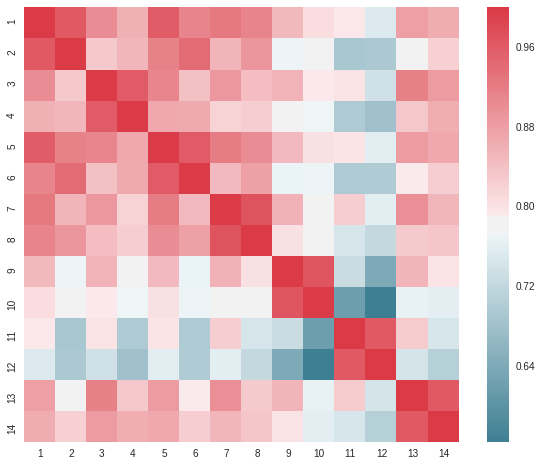

In [6]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Test of machine learning algorithms


* I decided here to use the features the most discriminant to determine the rules with trees. This class implements a meta estimator that fits a number of randomized decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

* I ranked the features iportances in order and injected it in the matrix M in linear. It gave me good results but improvable.

Feature ranking:
1. feature 8 (0.121502)
2. feature 13 (0.105185)
3. feature 9 (0.100683)
4. feature 11 (0.097187)
5. feature 5 (0.090615)
6. feature 12 (0.086775)
7. feature 14 (0.081564)
8. feature 7 (0.078939)
9. feature 10 (0.061649)
10. feature 1 (0.043523)
11. feature 4 (0.035391)
12. feature 2 (0.033040)
13. feature 3 (0.032038)
14. feature 6 (0.031911)


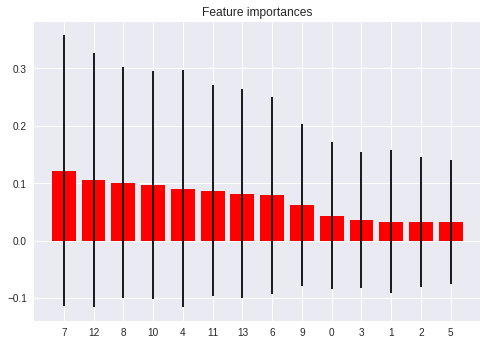

In [7]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100)

forest.fit(train, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()

* The PCA does an unsupervised dimensionality reduction, while the logistic regression does the prediction. I also use a GridSearchCV to set the dimensionality of the PCA.

* The idea here is to classify algorithms and take coefficient of the hyperplan to put it in the matrix.

* This method gave me the final result.

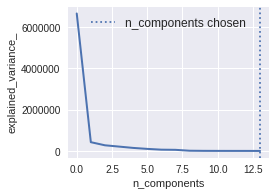

In [21]:
logistic = linear_model.LogisticRegression()
logistic.fit(train, y)

pca = decomposition.PCA(svd_solver='full')
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X = train
y = y

# Plot the PCA spectrum
pca.fit(X)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [13]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X, y)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [26]:
coefficients = pd.DataFrame(
    {"Feature": X.columns, "Coefficients": np.transpose(logistic.coef_).reshape(14)})
result = coefficients.sort_values(by='Coefficients', ascending=False)
log_coefs = result
log_coefs

,Coefficients,Feature
12,0.022238,13
6,0.021021,7
1,0.011833,2
3,0.007079,4
11,0.002010,12
9,0.000772,10
5,-0.000063,6
8,-0.001283,9
10,-0.002276,11
4,-0.003881,5


In [44]:
log_coefs.T.iloc[:,0]

Coefficients    0.0222378
Feature                13
Name: 12, dtype: object

* To respect the constraint of time running I kept the idea of determining the important features but by procceding by cross validation research.
* I took every column and I compute it with the next one in order to find the most relevant scores to put into the matrix.
* By elimination I kept the following columns who seemed the most important for the tree : 8, 9, 10, 11, 14

In [10]:
# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)

rf.fit(train, y)
#scores = cross_val_score(rf, train_, y, cv=5)
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 13 (0.375222)
2. feature 14 (0.287326)
3. feature 8 (0.102010)
4. feature 9 (0.098699)
5. feature 6 (0.088869)
6. feature 7 (0.011055)
7. feature 10 (0.010716)
8. feature 11 (0.010522)
9. feature 12 (0.007716)
10. feature 3 (0.002166)
11. feature 4 (0.001914)
12. feature 5 (0.001901)
13. feature 1 (0.001029)
14. feature 2 (0.000856)


In [11]:
train1 = train[['13', '14']]
train1.head()

# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)
rf.fit(train1, y)
scores = cross_val_score(rf, train1, y, cv=5)

importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train1.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 2 (0.598741)
2. feature 1 (0.401259)


In [12]:
train2 = train[['13', '14', '8']]

# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)
rf.fit(train2, y)
scores = cross_val_score(rf, train2, y, cv=5)

importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train2.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 2 (0.391243)
2. feature 1 (0.390222)
3. feature 3 (0.218535)


In [13]:
train3 = train[['13', '14', '8', '9']]

# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)
rf.fit(train3, y)
scores = cross_val_score(rf, train3, y, cv=5)

importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train3.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 1 (0.472801)
2. feature 2 (0.381956)
3. feature 3 (0.120898)
4. feature 4 (0.024344)


In [14]:
train4 = train[['13', '14', '8', '9', '6']]

# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)

rf.fit(train4, y)
scores = cross_val_score(rf, train4, y, cv=5)
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train4.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 2 (0.570669)
2. feature 3 (0.207708)
3. feature 1 (0.192896)
4. feature 4 (0.022914)
5. feature 5 (0.005813)


In [15]:
train6 = train[['13', '14', '8', '9', '6', '7']]

# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)

rf.fit(train6, y)
scores = cross_val_score(rf, train6, y, cv=5)
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train6.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 6 (0.204999)
2. feature 2 (0.202879)
3. feature 4 (0.198109)
4. feature 3 (0.195281)
5. feature 1 (0.193929)
6. feature 5 (0.004803)


In [16]:
train7 = train[['13', '14', '8', '9', '6', '7', '10']]

# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)

rf.fit(train7, y)
scores = cross_val_score(rf, train7, y, cv=5)
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train7.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 1 (0.287446)
2. feature 6 (0.199977)
3. feature 2 (0.197861)
4. feature 4 (0.106595)
5. feature 3 (0.102769)
6. feature 7 (0.099745)
7. feature 5 (0.005607)


In [17]:
train8 = train[['13', '14', '8', '9', '6', '7', '10', '11']]

# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)

rf.fit(train8, y)
scores = cross_val_score(rf, train8, y, cv=5)
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train8.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 1 (0.467034)
2. feature 3 (0.192539)
3. feature 4 (0.109767)
4. feature 6 (0.101561)
5. feature 2 (0.100222)
6. feature 8 (0.015925)
7. feature 7 (0.010561)
8. feature 5 (0.002392)


In [18]:
train9 = train[['13', '14', '8', '9', '6', '7', '10', '11', '12']]

# Random forest et features importance
rf = RandomForestClassifier(max_depth=10, random_state=0)

rf.fit(train9, y)
scores = cross_val_score(rf, train9, y, cv=5)
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train9.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 2 (0.287061)
2. feature 7 (0.190195)
3. feature 6 (0.103518)
4. feature 3 (0.103323)
5. feature 1 (0.103002)
6. feature 4 (0.100938)
7. feature 5 (0.091828)
8. feature 8 (0.011508)
9. feature 9 (0.008627)


* The trees helped me findind the most important columns. I used it for my matrix as we can see below in a quadratic way. 

    Coefficient of the features in the decision function.

In [53]:
M = np.zeros((15, 15))


M[0, 8] = log_coefs.iloc[0]['Coefficients']
M[0, 9] = log_coefs.iloc[0]['Coefficients']
M[0, 10] = log_coefs.iloc[0]['Coefficients']
M[0, 11] = log_coefs.iloc[0]['Coefficients']
M[0, 14] = log_coefs.iloc[0]['Coefficients']
M[8, 8] = log_coefs.iloc[0]['Coefficients']
M[9, 9] = log_coefs.iloc[0]['Coefficients']
M[10, 10] = log_coefs.iloc[0]['Coefficients']
M[11, 11] = log_coefs.iloc[0]['Coefficients']
M[14, 14] = log_coefs.iloc[0]['Coefficients']


cur_s = s_trn[0]
cur_s_hat = np.dot(cur_s.T, np.dot(M, cur_s))
print(cur_s_hat)

# Check if the time constraint is satisfied:

tot_dur = compute_total_time(M)
print(tot_dur)

if(tot_dur <= alg_time_thr):
    print("The total running time of the fusion is acceptable!")

    # Evaluation

    # apply fusion on scores
    fuse = np.multiply(s_trn[:, None, :] * s_trn[:, None, :], M)
    fuse = np.concatenate([np.reshape(
        y_trn, [-1, 1]), np.reshape(np.sum(fuse, axis=(1, 2)), [-1, 1])], axis=1)
    fuse[np.isnan(fuse)] = -float("inf")

    # compute the FRR at FAR = 0.01%
    look_at_FAR = 0.0001
    thr, fa, fr = compute_eval(fuse)
    print("Score at FAR=" + str(look_at_FAR * 100.0) + "%")
    print("threshold :", thr, "far :", fa, "frr :", fr)

else:
    print("The total running time of the fusion is NOT acceptable!")

2610661.61706
539.0
The total running time of the fusion is acceptable!


/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


Score at FAR=0.01%
threshold : 4506170.50082 far : 9.9610468009e-05 frr : 0.0815922930822


In [ ]:
# Better frr : 0.0815922930822

In [ ]:
#Submission

#Write the matrix M to the disk:
np.savetxt('M_pred.txt', M, fmt='%f')